<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Clasificación de dígitos con redes de convolución<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-03-05</small></i></div>
                                                  

***

## Introducción

En este _notebook_ vamos a crear un clasificador para el problema del `mnist` usando para ello un modelo de red neuronal convolucional (CNN).

Una CNN es una arquitectura un tanto diferente de red neuronal que, aunque mantiene su comportamiento _feed-forward_, aprovecha la estructura de los datos de entrada (normalmente imágenes, pero generalizando cualquier conjunto de datos donde los valores relacionados tienden a estar cerca) para reducir el tamaño del modelo y a la vez ofrecer un mejor desempeño.

## Objetivos

El objetivo será la implementación de la red neuronal convolucional, la cual compararemos con el MLP que implementamos anteriormente para comparar ambos.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del _notebook_.

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

Configuraremos también algunos parámetros para adecuar la presentación gráfica.

In [6]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (16, 9),'figure.dpi': 64})

***

## Preparación de los datos.

Vamos a ver un poco más en detalle los datos con los que vamos a trabajar. El conjunto `mnist` es un conjunto de imágenes pequeñas ($28 \times 28$ píxeles) con dígitos del 0 al 9 manuscritos.

![](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Ya hemos visto que `keras` nos ofrece un módulo para trabajar con este _dataset_ directamente sin preocuparnos. Vamos a cargarlo y a verlo un poco más en detalle.

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f'Training shape: {x_train.shape} input, {y_train.shape} output')
print(f'Test shape:     {x_test.shape} input, {y_test.shape} output')

Training shape: (60000, 28, 28) input, (60000,) output
Test shape:     (10000, 28, 28) input, (10000,) output


Vemos que el conjunto de datos se divide en un conjunto de datos de entrenamiento de 60000 ejemplos y un conjunto de test de 10000 ejemplos. El primero es con el que entrenaremos nuestro modelo mientras que el segundo servirá para evaluar el desempeño del modelo con datos que no ha visto nunca.

Veamos la forma que tienen los datos de entrada de un ejemplo en concreto:

In [8]:
INDEX = 42

print(x_train[INDEX])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1  26 111 195 230
   30   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  28 107 195 254 25

Cada uno de los ejemplos es una matrix de $28 \times 28$ valores numéricos que van del 0 al 255. Esto es porque sus valores son bytes que representan la intensidad del blanco, del 0 (totalmente negro) al 255 (totalmente blanco).

Vamos a representar a este número con la biblioteca matplotlib en un mapa de calor:

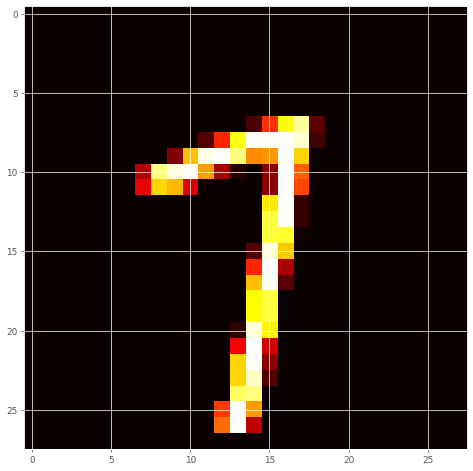

In [9]:
plt.imshow(x_train[INDEX], cmap='hot');

Cuando trabajamos con redes neuronales, lo más común es trabajar con entradas que están normalizadas al intervalo $[0, 1]$. Vamos a aprovechar la potencia de `numpy` y el _bradcasting_ (así se le llama a aplicar una función a todos los elementos de un vector o matriz) para normalizar los valores. Si el valor máximo es 255, el proceso es tan sencillo como sigue:

In [10]:
x_train = x_train / 255
x_test = x_test / 255

Acabamos de aplicar una división a ambos conjuntos de datos de entrada. Ahora, si mostramos el contenido de nuestro número (bueno, una porción) veremos que está normalizado:

In [11]:
print(x_train[INDEX][5:10])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.00392157 0.10196078 0.43529412 0.76470588 0.90196078
  0.11764706 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.10980392
  0

Pero la relación entre los valores no habrá cambiado, así que si vbemos el mapa de calor veremos que las diferencias relativas entre valores se han mantenido:

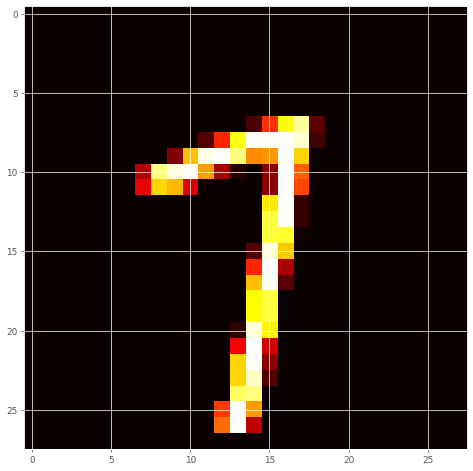

In [12]:
plt.imshow(x_train[INDEX], cmap='hot');

Por cierto, hemos elegido un número bastante curioso ya que es complicado decidir si se trata de un 1 o un 7 (al menos a mí). Veamos Su valor de salida y continuemos desde ahí:

In [13]:
print(y_train[INDEX])

7


Ahora lo que vamos a tratar es un problema relacionado con la **clasificación multiclase**. En el momento que trabajamos con dos clases, tener una neurona de salida que nos discrimina entre los dos tiene sentido. Supongamos que estamos con un problema para identificar si una foto se corresponde o no a un gato. Si usamos una neurona de salida con activación sigmoidal, cuanto más se acerque al 0 o al 1, más se alejará del 1 o del 0, o dicho de otro modo, cuando más seguros estemos de que es un gato, más seguros estaremos de que no es un no-gato.

Bueno, supongamos que queremos indicar si en una foto hay un gato, un perro o un oso. Con una neurona ¿qué hacemos? ¿Asignamos intervalos? Y recordemos que las redes funcionan con un proceso denominado descenso del gradiente que trabaja con pequeños incrementos de error. Al tener un rango de valores reales del 0 al 1, tenemos un orden entre estos valores. ¿Cómo colocamos los intervalos? ¿Es oso entre medias? ¿Es el oso una mezcla entre perro y gato? ¿Como vamos del perro al gato si el descenso del gradiente nos va a alejar del oso porque el error va a ser muy alto?

Bueno, la solución es usar tantas neuronas como clases que queremos clasificar. Cada neurona se corresponderá con un es/no es algo y al final escogeremos la neurona que mayor activación tenga. Y para ello, entre las utilidades de Keras existe una herramienta que convierte los valores numéricos a categóricos, realizando una codificación one_hot. Funcionará ordenando los valores y convirtiendo cada uno de los diferentes valores a una posición del vector de salida.

In [14]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train[INDEX])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Esta codificación nos convierte el valor numérico en un array ordenado donde se activa la neurona que se corresponde con la respuesta. De esta manera ya tenemos un valor de salida que podremos comparar con la salida de nuestra red, que será de 10 neuronas (10 números a clasificar. Y ahora sí, ya tenemos nuestros datos preparados.

## Creación del modelo

Vamos a crear una CNN sencilla, sin varias ramas independientes ni elementos raros, así que podemos usar el API secuencial sin problemas. Si nos acordamos, el modelo secuencial se crea como una lista de capas que se conectan una detrás de otra, pero hay otra forma que es llamando al método `add` de los objetos de la clase `Sequential`.

Comenzaremos creando el modelo de la clase `Sequential`:

In [15]:
model_cnn = tf.keras.Sequential()

Ahora añadiremos una capa oculta. Si nos acordamos de teoría, las CNN se componen de dos partes, la parte de extracción de características, compuesta de capas de convolución, y las capas de inferencia, compuestas de capas densas. Comenzaremos con una capa de convolución:

In [16]:
model_cnn.add(tf.keras.layers.Conv2D(
    input_shape=(28, 28, 1),
    kernel_size=(3, 3),
    filters=8,
    activation='relu',
))

Acabamos de crear una capa compuesta de 8 convoluciones de tamaño $3 \times 3 \times 1$ que navegará por toda la imagen extrayendo características.

Otra capa que se suele combinar con las de convolución son las de muestreo parcial, _subsampling_ o _pooling_. Si recordamos, se trataba de filtros que reducían la imágen sacando los valores más destacables de cada área que cubre el filtro. En este caso, usaremos una capa `MaxPooling2D` que escogerá el valor más alto del área que cubre, con un _stride_ del tamaño del filtro para que no ahya solapamiento. Esto reducirá bastante el tamaño de la salida de la capa anterior:

In [17]:
model_cnn.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

De momento vamos a mantener una única capa de convolución y una de _pooling_, vamos a saltar a la parte de inferencia.

Ahora bien, para saltar a la parte de inferencia (que no deja de ser un perceptrón multicapa) necesitamos que todos los datos de entrada estén en una dimensión. Por ello, antes de entrar en la capa de inferencia, vamos a "aplanar" la salida de la convolución:

In [18]:
model_cnn.add(tf.keras.layers.Flatten())

No necesitamos parámetros, lo único que hace es poner la matriz multidimensional en dos dimensiones, el número de ejemplos y todas las características extraídas para dicho ejemplo.

Ahora vamos a añadir las capas densas que queramos. Vamos a añadir una oculta primero:

In [19]:
model_cnn.add(tf.keras.layers.Dense(4, activation='relu'))

Y la de salida. Recordemos, la salida serán **10 neuronas**, una por cada posible clase.

In [20]:
model_cnn.add(tf.keras.layers.Dense(10, activation='softmax'))

La razon por la que añadimos una función de activación de tipo _softmax_ es debido a que:

1. La clase que hay que seleccionar es exclusiva, es decir, un ejemplo no puede pertenecer a varias clases a la vez.
2. _Softmax_ es derivable (de hecho, es la versión derivable de la función _argmax_), por lo que es posible aplicar el algoritmo del descenso del gradiente para entrenar la red.

Y con esto ya tenemos definido nuestro modelo. Veamos su estructura:

In [21]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1352)              0         
                                                                 
 dense_6 (Dense)             (None, 4)                 5412      
                                                                 
 dense_7 (Dense)             (None, 10)                50        
                                                                 
Total params: 5,542
Trainable params: 5,542
Non-trainable params: 0
____________________________________________________

Vamos a compararlo con un perceptrón multicapa de un par de capas ocultas con aproximadamente el mismo número de parámetros:

In [22]:
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(7, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model_mlp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 7)                 5495      
                                                                 
 dense_9 (Dense)             (None, 8)                 64        
                                                                 
 dense_10 (Dense)            (None, 10)                90        
                                                                 
Total params: 5,649
Trainable params: 5,649
Non-trainable params: 0
_________________________________________________________________


Ahora veamos qué tal se comportan en un par de entrenamientos. Para ello los entrenaremos con los mismos algoritmos y el mismo número de epochs. Empezamos con la CNN.

In [23]:
model_cnn.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
history_cnn = model_cnn.fit(x_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
1688/1688 [==============================] - 6s 3ms/step - loss: 1.4735 - categorical_accuracy: 0.4524 - val_loss: 0.9194 - val_categorical_accuracy: 0.6973
Epoch 2/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.8692 - categorical_accuracy: 0.7215 - val_loss: 0.6505 - val_categorical_accuracy: 0.7980
Epoch 3/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6435 - categorical_accuracy: 0.8045 - val_loss: 0.5229 - val_categorical_accuracy: 0.8390
Epoch 4/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5241 - categorical_accuracy: 0.8447 - val_loss: 0.4562 - val_categorical_accuracy: 0.8608
Epoch 5/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4417 - categorical_accuracy: 0.8714 - val_loss: 0.3852 - val_categorical_accuracy: 0.8845
Epoch 6/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3874 - categorical_accuracy: 0.8868 - val_loss: 0.3440 - val_categorical_accuracy:

1688/1688 [==============================] - 5s 3ms/step - loss: 0.1152 - categorical_accuracy: 0.9663 - val_loss: 0.1309 - val_categorical_accuracy: 0.9647
Epoch 50/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1144 - categorical_accuracy: 0.9663 - val_loss: 0.1235 - val_categorical_accuracy: 0.9647


Veamos la evolución de su error y su exactitud:

In [ ]:
pd.DataFrame(history_cnn.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Ahora seguimos con el MLP:

In [ ]:
model_mlp.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
history_mlp = model_mlp.fit(x_train, y_train, epochs=50, validation_split=0.1)

Y veamos también la evolución de su error y su exactitud:

In [ ]:
pd.DataFrame(history_mlp.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Parece que, aunque el MLP funciona bastante bien, la red no es capaz de llegar a tanta precisión como la CNN. Tiene sentido, ya que muchos de los parámetros se ocupan de relacionar píxeles que probablemente tengan muy poco que ver. Veamos qué tal se comportan con el conjunto de test:

In [ ]:
loss_cnn, acc_cnn = model_cnn.evaluate(x_test, y_test)
loss_mlp, acc_mlp = model_mlp.evaluate(x_test, y_test)

print(f'Results for CNN: Loss={loss_cnn}, acc={acc_cnn}')
print(f'Results for MLP: Loss={loss_mlp}, acc={acc_mlp}')

Además hemos hecho una pequeña trampa. Nuestra red de convolución sólo tiene una capa, y esto provoca que el resultado sea muy grande. Este, al conectarlo con la capa densa hace que el número de parámetros crezca dramáticamente.

Vamos a tratar de solucionar esto y a comparar con un nuevo perceptrón.

In [ ]:
model = tf.keras.models.Sequential([
    # Capa convolucional
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=8, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2)),
    # Capa convolucional
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=8, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2)),
    # Aplanamos características
    tf.keras.layers.Flatten(),
    # Inferencia
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
model.summary()

Casi la mitad de parámetros. Veamos su desempeño:

In [ ]:
history = model.fit(x_train, y_train, epochs=50, validation_split=0.1)

Gráficamente, la evolución queda como sigue:

In [ ]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Parece un entrenamiento más estable y con mejores valores. Comparemos ahora los resultados de los tres modelos con el conjunto de test.

In [ ]:
loss, acc = model.evaluate(x_test, y_test)

print(f'Results for CNN 2.0: Loss={loss}, acc={acc}')
print(f'Results for CNN:     Loss={loss_cnn}, acc={acc_mlp}')
print(f'Results for MLP:     Loss={loss_mlp}, acc={acc_cnn}')

El modelo generaliza mejor que el resto y además ocupa casi la mitad. Parece que la arquitectura de CNN se comporta bastante mejor para este tipo de problemas.

Sin embargo, tiene un problema que es probable que hayamos identificado: La velocidad de entrenamiento. Después de todo, las operaciones de convolución son más lentas que un simple producto de matrices.

## Modelos LeNet y AlexNet

El modelo de red convolucional LeNet es una de las primeras redes neuronales que usaron opreaciones de convolución. Fue propuesta por Yann LeCun [1] en 1989 para el problema del reconocimiento (i.e. clasificación) de números manuscritos

LeNet es el modelo en el que se inspira AlexNet [2], el modelo de que ganó la competición ImageNet en 2012 y que se considera como el origen de la vorágine del deep learning que nos ha traído hasta el momento actual.

<figure>
    <center>
        <img src="Images/lenet-vs-alexnet.svg" alt="Lenet vs AlexNet" style="width:100%" />
        <figcaption align = "center"><strong>Figura 1</strong>. Diferencias entre arquitecturas LeNet y AlexNet. Autor: <a href="http://commons.wikimedia.org/wiki/User:Cmglee" title="User:Cmglee">Cmglee</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=104937230">Link</a></figcaption>
    </center>
</figure>

Fijémonos en el año del primero. Usaron los algoritmos de retropropagación recién propuestos (1986, aunque es cierto que la técnica tiene predecesores) para el entrenamiento de los filtros de convolución. Por ello, sus autores se consideran pioneros en la clasificación de imágenes.

Crearemos ahora estas arquitecturas para ver cómo se comportan con este conjunto de datos.

### Arquitectura LeNet

Existen muchas variantes diferentes. Nosotros implementaremos la mostrada en la Figura 1, pero no es la original (partiendo de que esta además toma como entrada imágenes de $32 \times 32$.

In [ ]:
lenet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, 5, padding='same', activation='sigmoid', input_shape=(28, 28, 1)),
    tf.keras.layers.AveragePooling2D(2),
    tf.keras.layers.Conv2D(16, 5, activation='sigmoid'),
    tf.keras.layers.AveragePooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='sigmoid'),
    tf.keras.layers.Dense(84, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
lenet.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
lenet.summary()

Esta arquitectura tiene bastantes más parámetros que las que hemos estado tratando hasta ahora. Veamos cómo progresa el entrenamiento durante 50 epochs como en los anteriores ejemplos.

In [ ]:
lenet_history = lenet.fit(x_train, y_train, epochs=50, validation_split=0.1)

Gráficamente, la evolución queda como sigue:

In [ ]:
pd.DataFrame(lenet_history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

### Arquitectura AlexNet

Como hemos visto, la arquitectura AlexNet es una ampliación de la arquitectura LeNet, diseñada para la competición ImageNet que consistía en la clasificación de imágenes de $224 \times 224 \times 3$ en una entre mil clases.

A diferencia que con LeNet, aquí implementaremos una versión un tanto diferente a la de la Figura 2:

1. a última capa no será de 1000, sino de 10, ya que las clases en las que clasificar son 10 dígitos
2. Reduciremos las dimensiones de los filtros de convolución y _pooling_ ya que la imagen de entrada no es lo suficientemente grande para soportarlos (se reducen por debajo de cero píxeles)
3. También eliminaremos los _strides_ por el mismo motivo.

In [4]:
alexnet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax'),
])
alexnet.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 96)        960       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 256)       221440    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 6, 384)        

Esta arquitectura tiene bastantes más parámetros que las que hemos estado tratando hasta ahora. Además incluye dos capas de _dropout_, en las que entraremos en detalle más adelante. Por ahora están ahí y sirven para reducir el overfitting durante el entrenamiento.

Veamos cómo progresa el entrenamiento durante 50 epochs como en los anteriores ejemplos.

In [ ]:
alexnet_history = lenet.fit(x_train, y_train, epochs=50, validation_split=0.1)

Gráficamente, la evolución queda como sigue:

In [ ]:
pd.DataFrame(alexnet_history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Veamos una comparativa entre todos los modelos:

In [ ]:
lenet_loss, lenet_acc = lenet.evaluate(x_test, y_test)
alexnet_loss, alexnet_acc = alexnet.evaluate(x_test, y_test)

print(f'Results for AlexNet: Loss={alexnet_loss}, acc={alexnet_acc}')
print(f'Results for LeNet:   Loss={lenet_loss}, acc={lenet_acc}')
print(f'Results for CNN 2.0: Loss={loss}, acc={acc}')
print(f'Results for CNN:     Loss={loss_cnn}, acc={acc_mlp}')
print(f'Results for MLP:     Loss={loss_mlp}, acc={acc_cnn}')

Quizá en este ejemplo no es apreciable la potencia de estos modelos respecto a los anteriores, pero lo cierto es que los superan su desempeño en varios órdenes de magnitud en problemas más complejos... y también en tiempo de entrenamiento.

## Conclusiones

Las redes convolucionales son una arquitectura de red neuronal que aprovecha las características de la entrada para aprender las relaciones existentes. Es equivalente a aproximar un problema de forma más inteligente que la fuerza bruta.

Su principal desventaja es la velocidad de entrenamiento, pero superan con creces la capacidad de resolución de problemas cuando tratamos con elementos como imágenes.

Más adelante veremos otros tipos de redes que solucionan ciertos problemas o que permiten que éstas sean todavía más grandes.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>